In [18]:
import json

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from pyobsbox import ObsBoxGenerator
import matplotlib.pyplot as plt

from paths import metadata_folder, models_folder

In [19]:
metadata_path = metadata_folder / "metadata_B1H_Inst_34994.h5"
metadata_df = pd.read_hdf(metadata_path, "metadata")
# remove date time index
metadata_df = metadata_df.reset_index()

generator = ObsBoxGenerator(
    metadata_df,
    metadata_path=metadata_path,
    n_bunches=256,
    sequence_length=2048,
    shuffle=True,
    normalization="raw",
)

Feb/04 16:21:52 pyobsbox.generator INFO: Completing 'batch_size'.
Feb/04 16:21:52 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/04 16:21:52 pyobsbox.generator INFO: shuffle: True
Feb/04 16:21:52 pyobsbox.generator INFO: batch_size: 8192
Feb/04 16:21:52 pyobsbox.generator INFO: sequence_length: 2048
Feb/04 16:21:52 pyobsbox.generator INFO: n_bunches: 256
Feb/04 16:21:52 pyobsbox.generator INFO: __len__: 45802
Feb/04 16:21:52 pyobsbox.generator INFO: fetched_log_folder: None
Feb/04 16:21:52 pyobsbox.generator INFO: fetched_log_prefix: 
Feb/04 16:21:52 pyobsbox.generator INFO: normalization: raw


In [32]:
data = [generator[i][0] for i in tqdm(range(100))]
data = np.vstack(data)

In [36]:
standard_devs = np.std(data, axis=1)

In [37]:
standard_devs.shape

(819200, 1)

In [38]:
abs_max = np.max(np.abs(data), axis=1)

In [39]:
abs_max.shape

(819200, 1)

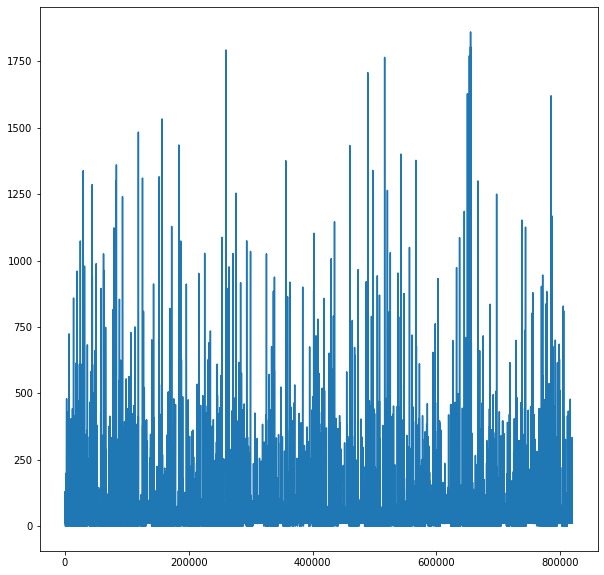

In [40]:
plt.figure(figsize=(10, 10))
plt.plot(np.hstack(standard_devs))

In [26]:
np.percentile(standard_devs, 99.9)

165.4093834717809

In [27]:
data.shape

(819200, 2048, 1)

In [11]:
plt.figure(figsize=(10, 10))
plt.plot(data[standard_devs >= np.percentile(standard_devs, 99.9)].T);

IndexError: boolean index did not match indexed array along dimension 1; dimension is 2048 but corresponding boolean dimension is 1

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(data[standard_devs <= np.percentile(standard_devs, 1)].T);

The standard deviation is a very good indicator of weirdness in the obsbox signal.

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(np.hstack(abs_max));

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(data[abs_max >= np.percentile(abs_max, 99.9)].T);

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(data[abs_max <= np.percentile(abs_max, 1)].T);

So is the absolute max value, but it is statisticaly less stable.

# Looking at the ranges of the data

In [41]:
data.shape

(819200, 2048, 1)

In [42]:
data.max()

15154.0

In [43]:
data.min()

-11780.0

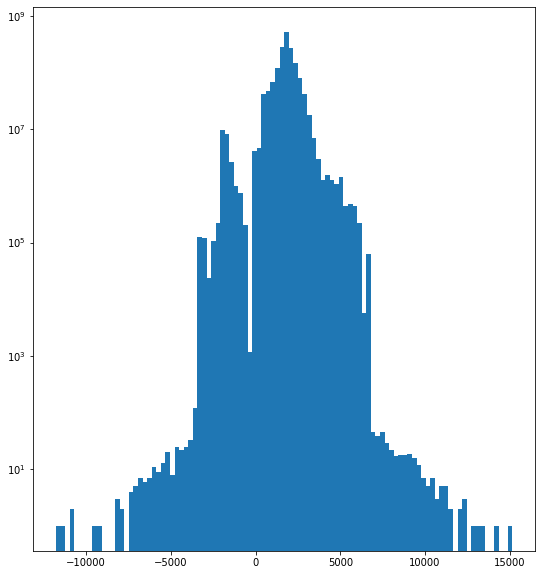

In [29]:
plt.figure(figsize=(9, 10))
plt.hist(data.squeeze().flatten(), bins=100)
plt.yscale('log');

# Constant rescaling factors

I want to find a value with which to rescale the signal which makes sense to use for the entire dataset.

In [ ]:
np.max(abs_max)

Using the max might cause problems, because the dynamic range of the activation functions will be greatly reduces for al lthe signals in the dataset.

In [ ]:
np.percentile(abs_max, 99)

Using a percentile would improve the dynamic range for most of the signals and only a small subset of the dataset will be out of the dynamic range of the activation function.

In [ ]:
data_centered = data - np.mean(data, axis=1)[:, None]
data_centered_abs = np.abs(data_centered)

In [ ]:
np.percentile(data_centered_abs.flatten(), 99.73)

In [ ]:
data_centered.max()

In [ ]:
data_centered.mean()

# Proposed normalization method

Using the min/max

In [ ]:
data_norm = data_centered / 3406.0

In [ ]:
np.mean(data_norm, axis=1)

In [ ]:
np.max(data_norm, axis=1)

In [ ]:
data_norm.shape

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(data_norm[:10, :].T);

Using the std

In [ ]:
data_norm = data_centered / 3406.0

In [ ]:
np.std(data_norm)

# Normalize before splitting maybe ?

In [ ]:
generator = ObsBoxGenerator(
    metadata_df,
    metadata_path=metadata_path,
    n_bunches=1,
    sequence_length=2048,
    shuffle=False,
    normalization="presplit_znorm",
)

In [ ]:
data = generator[0][0]

In [ ]:
data.shape

In [ ]:
np.mean(data.flatten())

In [ ]:
np.std(data.flatten())

In [ ]:
plt.plot(data.flatten())